# Imports

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv("./university_rank_no_nan.csv", index_col=0, sep=";")

# Ustvarite nov stolpec Status. Vse univerzitete, ki imajo Rank:
- manjši od 200, naj imajo status prestigious (prestižne),
- večji od 200 in manjši od 300, naj imajo status reputable (ugledne),
- večji od 300 in manjši od 430, naj imajo status average (povprečne),
- večji od 430, naj imajo status badReputation (slab sloves).

In [66]:
prestigious = df["Rank"] < 200
reputable = (200 <= df["Rank"]) & (df["Rank"] <= 300)
average = (300 < df["Rank"]) & (df["Rank"] <= 430)
badReputation = 430 < df["Rank"]

df["Status"] = np.nan
df["Status"] = df["Status"].fillna(prestigious.map(({True: "prestigious"})))
df["Status"] = df["Status"].fillna(reputable.map({True: "reputable"}))
df["Status"] = df["Status"].fillna(average.map({True: "average"}))
df["Status"] = df["Status"].fillna(badReputation.map({True: "bad_reputation"}))

print(df.head(10))

                                              Country  Number_students  \
University of Oxford                   United Kingdom           20.664   
California Institute of Technology      United States            2.240   
University of Cambridge                United Kingdom           18.978   
Stanford University                     United States           16.135   
Massachusetts Institute of Technology   United States           11.247   
Princeton University                    United States            7.983   
Harvard University                      United States           20.823   
Yale University                         United States           12.402   
University of Chicago                   United States           13.833   
Imperial College London                United Kingdom           16.760   

                                       Numb_students_per_Staff  Score_Result  \
University of Oxford                                      11.2          95.4   
California Institute of T

# Izrišite graf, ki bo prikazoval, koliko je univerz s posameznim statusom.

AxesSubplot(0.125,0.11;0.775x0.77)


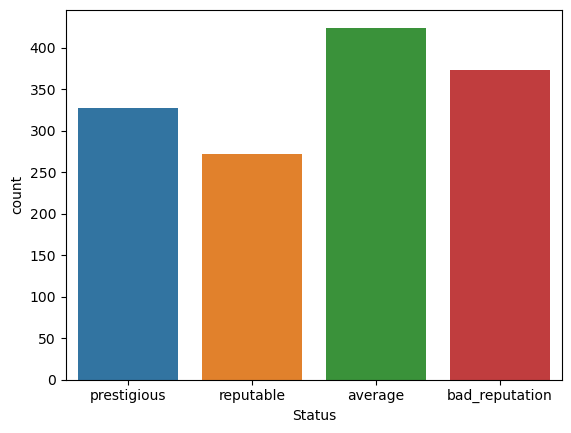

In [67]:
print(sns.countplot(x='Status', data=df))

# Preverite kakšen status sta dobili slovenski univerzi.

In [68]:
slo_universities = df.loc[df['Country'].isin(["Slovenia"])]

print(slo_universities["Status"])

University of Ljubljana    average
University of Maribor      average
Name: Status, dtype: object


# Klasifikacija

### Prva izvedva:
- Ustvarite kopijo df in jo poimenujte df1.
- Kategorične (nominalne) podatke iz df1 pretvorite v številske s pomočjo LabelEncoder. Pazite da ne pretvorite tudi podatkov izhodnega razreda.
- Številske podatke standardizirajte.
- Uporabite klasifikacijski algoritem nad prilagojenimi podatki iz df1.
- Izpišite točnost klasifikacije.

In [69]:
df_1 = df.copy(deep=True)

numerical_columns = df_1.select_dtypes(float).columns.tolist()

categorical_columns = df_1.select_dtypes(object).columns.tolist()
categorical_columns.pop()
print(categorical_columns)

for col in categorical_columns:
    df_1[col] = LabelEncoder().fit_transform(df_1[col])

df_1[numerical_columns] = StandardScaler().fit_transform(df_1[numerical_columns])

print(df_1.head())

['Country', 'International_Outlook']
                                       Country  Number_students  \
University of Oxford                        88        -0.115104   
California Institute of Technology          89        -0.366056   
University of Cambridge                     88        -0.138069   
Stanford University                         89        -0.176793   
Massachusetts Institute of Technology       89        -0.243372   

                                       Numb_students_per_Staff  Score_Result  \
University of Oxford                                 -0.461506      3.577682   
California Institute of Technology                   -0.746721      3.524553   
University of Cambridge                              -0.479332      3.518650   
Stanford University                                  -0.693243      3.512747   
Massachusetts Institute of Technology                -0.615997      3.471424   

                                           Rank  Teaching  Research  \
Universi

In [70]:
df_1.drop('Rank', axis=1, inplace=True)
df_1.drop('Score_Result', axis=1, inplace=True)

X = df_1.drop('Status', axis=1)
y = df_1["Status"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
model = RandomForestClassifier(n_estimators=60)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print("Accuracy: ", metrics.accuracy_score(predictions, y_test))

Accuracy:  0.8911174785100286


### Druga izvedva:
- Ustvarite kopijo df in jo poimenujte df2.
- Kategorične (nominalne) podatke iz df2 pretvorite v indikacijske parametre (dummy variable). Pazite da ne pretvorite tudi podatkov izhodnega razreda.
- Številske podatke standardizirajte.
- Uporabite klasifikacijski algoritem nad prilagojenimi podatki iz df2.
- Izpišite točnost klasifikacije.

In [71]:
df_2 = df.copy(deep=True)
categorical_columns = df_2.select_dtypes(object).columns.tolist()
categorical_columns.pop()

df_2 = pd.get_dummies(df_2, columns=categorical_columns)

numerical_columns = df_2.select_dtypes(float).columns.tolist()
df_2[numerical_columns] = StandardScaler().fit_transform(df_2[numerical_columns])

df_2.drop('Rank', axis=1, inplace=True)
df_2.drop('Score_Result', axis=1, inplace=True)

X = df_2.drop('Status', axis=1)
y = df_2["Status"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
model = RandomForestClassifier(n_estimators=60)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print("Accuracy: ", metrics.accuracy_score(predictions, y_test))

Accuracy:  0.8911174785100286


## Optimizacija nastavitev parametrov za algoritem naključnega gozda s pomočjo naključnega iskanja.

In [72]:

parameters = {
    "n_estimators": sp_randint(1, 1500),
    "max_depth": sp_randint(2, 50),
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2"],
}

clf = RandomizedSearchCV(RandomForestClassifier(),
                         param_distributions=parameters,
                         cv=5,
                         n_iter=50,
                         scoring='accuracy')

clf.fit(X, y)

print('Najboljše vrednosti parametrov so:', clf.best_params_)
print('Najboljši rezultat je:', clf.best_score_)
print('Najboljša uporaba v kodi je:', clf.best_estimator_)

/opt/homebrew/Caskroom/miniforge/base/envs/4_vaja/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/4_vaja/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/4_vaja/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

Najboljše vrednosti parametrov so: {'criterion': 'gini', 'max_depth': 38, 'max_features': 'auto', 'n_estimators': 235}
Najboljši rezultat je: 0.8131694828469023
Najboljša uporaba v kodi je: RandomForestClassifier(max_depth=38, max_features='auto', n_estimators=235)
